# This Notebook presents an expriment of Theory Of Mind on Schelling Coordination Game

In [2]:
# Import libraries.
using Turing, StatsPlots, Random, Plots, Memoization


We have 2 players: Bob and Alice.
They Want to arrive to the same point. they can't communicate, they only can infernce about each other.
We will model it using PPL. And use Practicle Gibbs Sampling.

In [2]:
function get_random_sample(samples)
    return Random.rand(samples)
end

get_random_sample (generic function with 1 method)

In [3]:
function get_most_common_sample(samples)
    count = zeros(2)
    for i in 1:length(samples)
        sample = round(Int64, samples[i] + 1) 
        count[sample] += 1 
    end
    if count[1] > count[2]
        return 0
    else
        return 1
    end
end

get_most_common_sample (generic function with 1 method)

In [23]:
@memoize memoized_sample(args...) = sample(args..., progress = false)

memoized_sample (generic function with 1 method)

In [17]:
function get_location(samples)
#     return samples[:my_location][end]
    return get_most_common_sample(samples[:my_location])
#     return get_random_sample(samples[:my_location])
end

get_location (generic function with 1 method)

In [18]:
@model function location_prior(popularity=0.55)
    popular_bar ~ Bernoulli(popularity)
    return popular_bar
end

location_prior (generic function with 2 methods)

In [19]:
@model function bob(depth = 0, popularity=0.55)
    my_location ~ Bernoulli(popularity)
    return round(Int64, my_location)
end

bob (generic function with 3 methods)

In [20]:
@model function alice(other_person_place, popularity = 0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    other_location = get_location(memoized_sample(other_person_place(), IS(), 10000))
    other_location ~ Dirac(my_location)
    return round(Int64, my_location)
end

alice (generic function with 3 methods)

In [21]:
samples = memoized_sample(alice(bob), PG(5), 10000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×4×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = my_location, other_location
internals         = logevidence, lp

Summary Statistics
      parameters      mean       std   naive_se      mcse         ess      rha ⋯
          Symbol   Float64   Float64    Float64   Float64     Float64   Float6 ⋯

     my_location    0.5558    0.4969     0.0050    0.0051   9884.7150    0.999 ⋯
  other_location    0.5558    0.4969     0.0050    0.0051   9884.7150    0.999 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

     my_location    0.0000    0.0000    1.0000    1.0000    1.0000
  other_location    0.0000    0.0000    1.0000    1.0000    1.0000


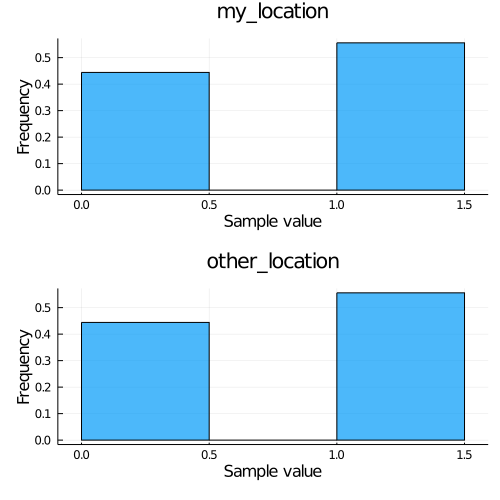

In [22]:
histogram(samples, bins = 2, normalize=:probability)

In [24]:
@model function alice_2(other_person_place, popularity = 0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    samples = memoized_sample(other_person_place(alice_2, popularity, depth - 1), IS(), 10000)
    other_location = get_location(samples)
    other_location ~ Dirac(my_location)
    return my_location
end

alice_2 (generic function with 3 methods)

In [31]:
@model function bob_2(other_person_place, popularity=0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    if depth == 0
       return my_location 
    else
        other_location = get_location(memoized_sample(other_person_place(bob_2, popularity, depth), SMC(), 10000))
        other_location ~ Dirac(my_location)
        return my_location
    end
end

bob_2 (generic function with 3 methods)

In [35]:
@time begin
    result = sample(alice_2(bob_2, 0.55, 20), IS(), 100000)
end

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:20


 21.576599 seconds (34.44 M allocations: 9.495 GiB, 13.54% gc time)


Chains MCMC chain (100000×3×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:100000
Thinning interval = 1
Chains            = 1
Samples per chain = 100000
parameters        = my_location, other_location
internals         = lp

Summary Statistics
      parameters      mean       std   naive_se      mcse          ess      rh ⋯
          Symbol   Float64   Float64    Float64   Float64      Float64   Float ⋯

     my_location    0.5482    0.4977     0.0016    0.0015   99097.8950    1.00 ⋯
  other_location    0.5482    0.4977     0.0016    0.0015   99097.8950    1.00 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

     my_location    0.0000    0.0000    1.0000    1.0000    1.0000
  other_location    0.0000    0.0000    1.0000    1.0000    1.0000


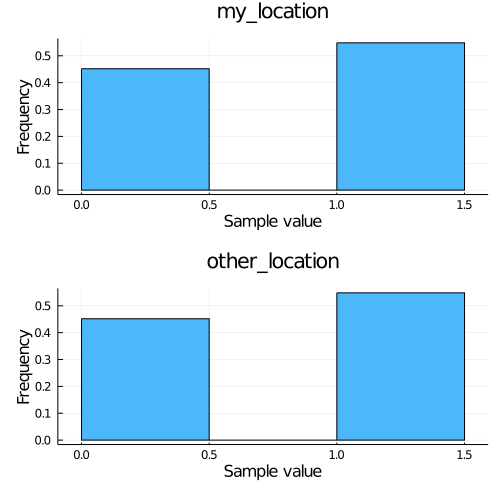

In [36]:
histogram(result, bins = 2, normalize=:probability)